In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import torch

from grconvnet.dataloading.datasets import YCBSimulationData
from grconvnet.preprocessing import Preprocessor, CenterCropResized, Masker
from grconvnet.postprocessing import Postprocessor, SkGaussian, Scaler, GraspLocalizer
from grconvnet.models import GenerativeResnet
from grconvnet.utils import visualization as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dataset = YCBSimulationData(
    Path("/home/moritz/Documents/ycb_sim_data_1"),
    transform=Preprocessor(
        reformatter=CenterCropResized((224, 224)),
        masker=Masker(negative_value=[255, 255, 255], positive_value=[0, 0, 0]),
    ),
)

device = "cuda"
model = GenerativeResnet.from_jit(device=device)

postprocessor = Postprocessor(
    q_blurrer=SkGaussian(2),
    angle_blurrer=SkGaussian(2),
    width_blurrer=SkGaussian(1),
    width_scaler=Scaler(150),
    grasp_localizer=GraspLocalizer(min_distance=20, threshold=0.2, n_grasps=5),
)

In [16]:
sample = dataset[9]
sample = sample.to(device)

with torch.no_grad():
    predictions = model(sample.unsqueeze(0))

grasps_img = postprocessor(predictions)

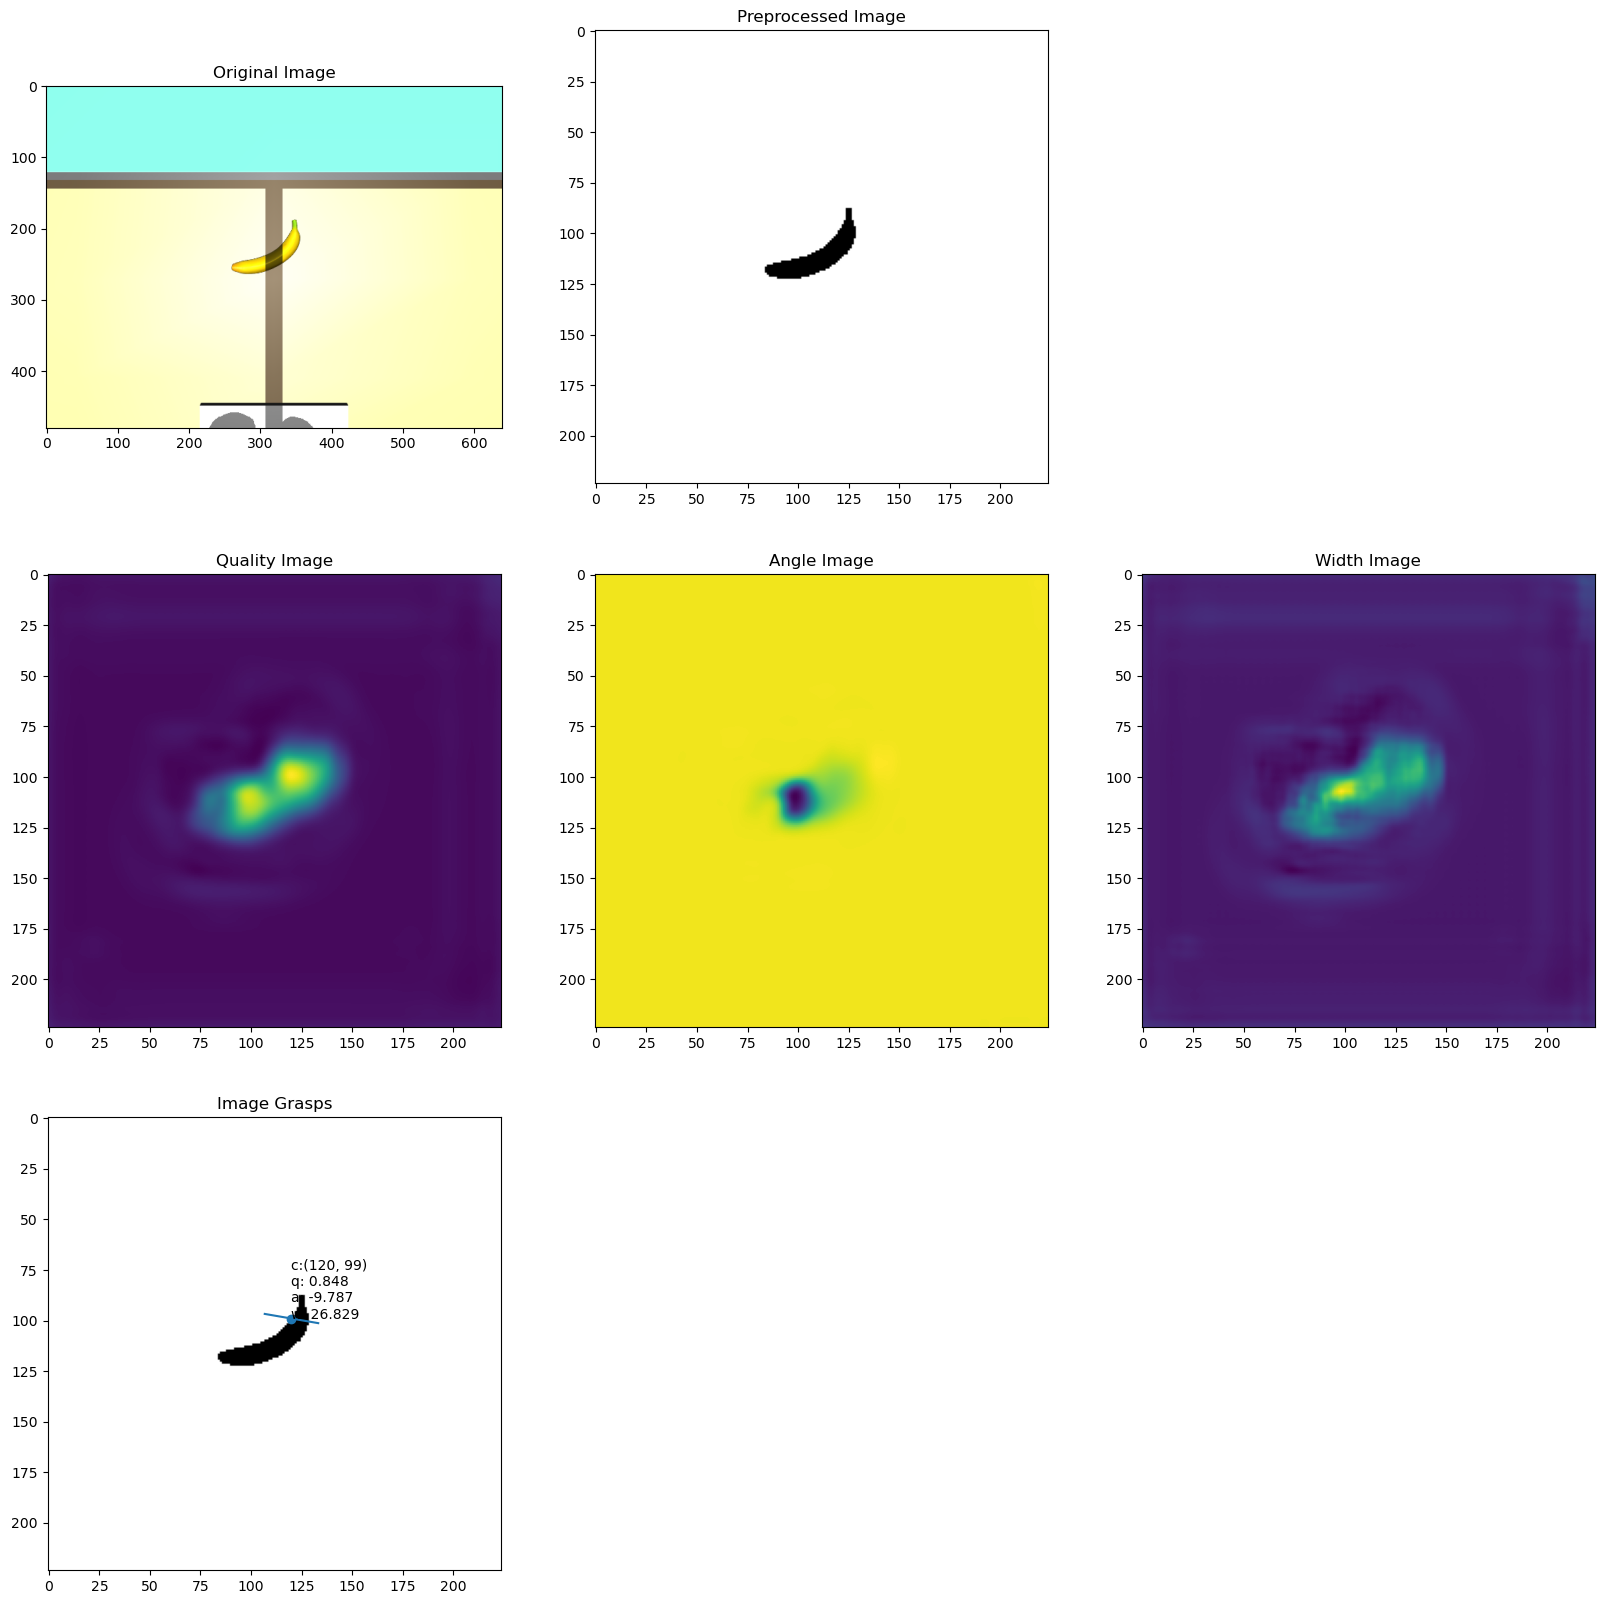

In [17]:
fig = vis.overview_fig(
    fig=plt.figure(figsize=(20,20)),
    original_rgb=vis.make_tensor_displayable(dataset.transform.intermediate_results["initial_sample"].rgb, True, True),
    preprocessed_rgb=vis.make_tensor_displayable(dataset.transform.intermediate_results["rgb_masked"], True, True),
    q_img=vis.make_tensor_displayable(postprocessor.intermediate_results["q_img"], False, False),
    angle_img=vis.make_tensor_displayable(postprocessor.intermediate_results["angle_img"], False, False),
    width_img=vis.make_tensor_displayable(postprocessor.intermediate_results["width_img"], False, False),
    image_grasps=grasps_img,
)

plt.show()